# Feature detection

In this notebook we are going to have a detailed look at the feature detection of tobac and explore the parameters of the according function.

In [1]:
import tobac
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

%matplotlib inline

## Minima/Maxima and Thresholds

When working different inputs

In [2]:
data = tobac.testing.make_sample_data_2D_3blobs()
inv_data = -data

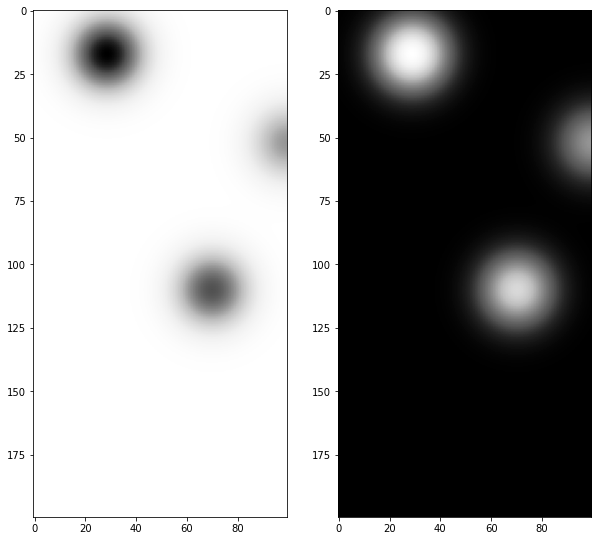

In [3]:
n = 50

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 10))

ax1.imshow(data.data[50], cmap = 'Greys')
#ax1.colorbar()

ax2.imshow(inv_data.data[50], cmap = 'Greys')

In [4]:
%%capture

dxy, dt = tobac.utils.get_spacings(data)

thresholds = [i for i in range(9, 18)]
inv_thresholds = [-i for i in range(9, 18)]
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, thresholds, target = 'maximum')
features_inv = tobac.themes.tobac_v1.feature_detection_multithreshold(inv_data, dxy, inv_thresholds, target = 'minimum')

Text(0, 0.5, 'threshold')

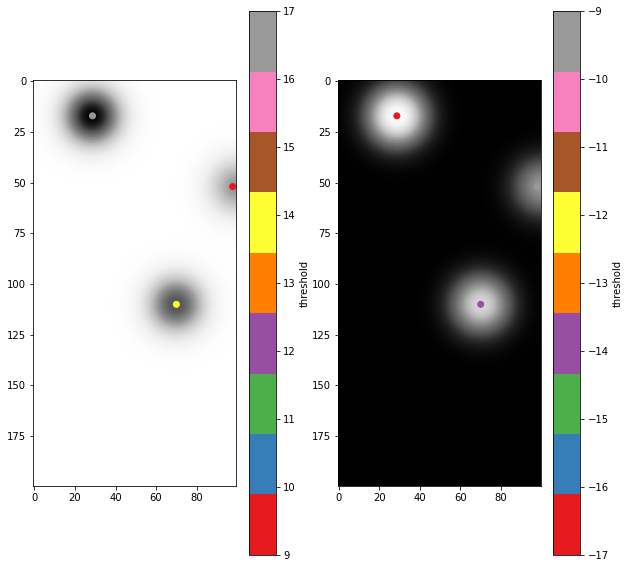

In [5]:
mask_1 = features['frame'] == n
mask_2 = features_inv['frame'] == n

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (10, 10))

ax1.imshow(data.data[50], cmap = 'Greys')
im1 = ax1.scatter(features.where(mask_1)['hdim_2'], features.where(mask_1)['hdim_1'], c = features.where(mask_1)['threshold_value'], cmap = 'Set1')
cbar = plt.colorbar(im1, ax = ax1)
cbar.ax.set_ylabel('threshold')

ax2.imshow(inv_data.data[50], cmap = 'Greys')
im2 = ax2.scatter(features_inv.where(mask_2)['hdim_2'], features_inv.where(mask_2)['hdim_1'], c = features_inv.where(mask_2)['threshold_value'], cmap = 'Set1')
cbar = plt.colorbar(im2, ax = ax2)
cbar.ax.set_ylabel('threshold')

## Position

To explore the influence of the position_threshold flag we need an asymmetric dataset. Let's create a simple one by adding two 2d-gausians and add an extra dimension for the time, which is required for working with tobac:

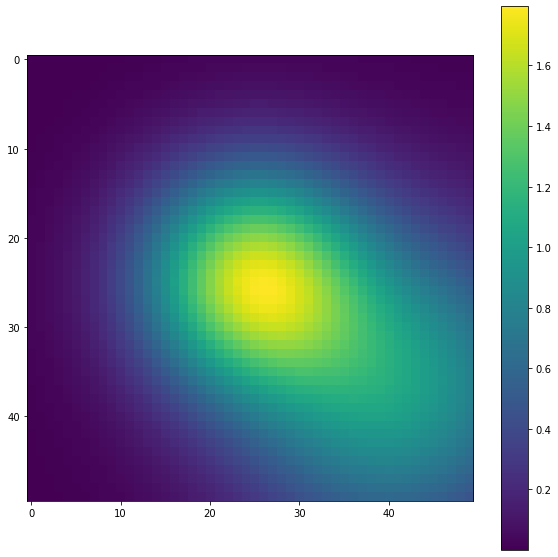

In [6]:
x = np.linspace(-2, 2)
y = np.linspace(-2, 2)
xx, yy = np.meshgrid(x, y)

asymmetric_data = np.expand_dims(1.5*np.exp(-(xx**2+yy**2)) + np.exp(-0.5*((1.3-xx)**2+(1-yy)**2)), axis=0)

plt.figure(figsize=(10,10))
plt.imshow(asymmetric_data[0])
plt.colorbar()

To feed this data into the feature detection we need to convert it into an xarray-DataArray. Before we do that we we select an arbitrary time and date for the single frame of our synthetic field:

In [7]:
date = np.datetime64('2022-04-01T00:00', )
assym = xr.DataArray(data=asymmetric_data, coords={'time':np.expand_dims(date, axis = 0),'y':y, 'x':x})
assym

<xarray.DataArray (time: 1, y: 50, x: 50)>
array([[[5.51160812e-04, 7.55457547e-04, 1.02253476e-03, ...,
         1.05601518e-02, 9.86863887e-03, 9.19825595e-03],
        [7.53943407e-04, 1.03373242e-03, 1.39956074e-03, ...,
         1.35432506e-02, 1.26370131e-02, 1.17637838e-02],
        [1.01865716e-03, 1.39706195e-03, 1.89190148e-03, ...,
         1.72510579e-02, 1.60727170e-02, 1.49437378e-02],
        ...,
        [3.98395277e-03, 5.26620302e-03, 6.90685653e-03, ...,
         6.11878262e-01, 5.83315636e-01, 5.52469521e-01],
        [3.52507621e-03, 4.64952832e-03, 6.08614455e-03, ...,
         5.69235217e-01, 5.42737773e-01, 5.14093239e-01],
        [3.12209629e-03, 4.11003441e-03, 5.37054169e-03, ...,
         5.26106788e-01, 5.01672875e-01, 4.75237494e-01]]])
Coordinates:
  * time     (time) datetime64[ns] 2022-04-01
  * y        (y) float64 -2.0 -1.918 -1.837 -1.755 ... 1.755 1.837 1.918 2.0
  * x        (x) float64 -2.0 -1.918 -1.837 -1.755 ... 1.755 1.837 1.918 2.0

Since we do not have a dt in this dataset, we can not use the get_spacings-utility this time and need to calculate the spacing manually:

In [8]:
dxy = (assym['x'][1] - assym['x'][0])

Finally, we choose a threshold in the datarange and apply the feature detection with the four position_threshold flags
- 'center'
- 'extreme'
- 'weighted_diff'
- 'weighted_diff'

In [9]:
%%capture

threshold = 0.4
features_center = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='center')
features_extreme = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='extreme')
features_diff = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='weighted_diff')
features_abs = tobac.themes.tobac_v1.feature_detection_multithreshold(assym, dxy, threshold, position_threshold='weighted_diff')                       

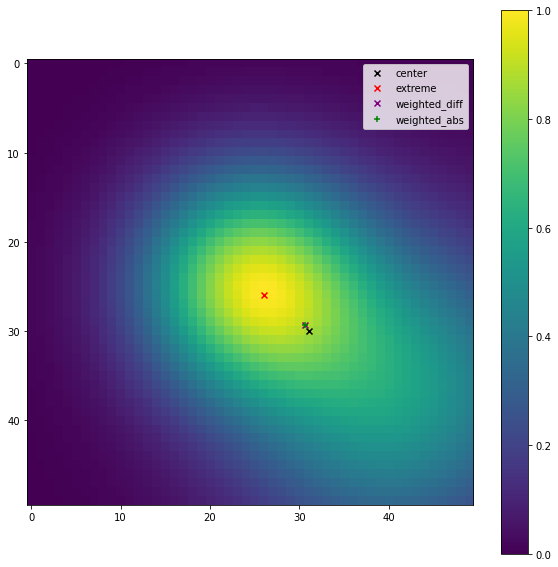

In [10]:
plt.figure(figsize = (10, 10))
plt.imshow(assym[0])
plt.scatter(features_center['hdim_2'], features_center['hdim_1'], color = 'black', marker = 'x', label = 'center')
plt.scatter(features_extreme['hdim_2'], features_extreme['hdim_1'], color = 'red', marker = 'x', label = 'extreme')
plt.scatter(features_diff['hdim_2'], features_diff['hdim_1'], color = 'purple', marker = 'x', label = 'weighted_diff')
plt.scatter(features_abs['hdim_2'], features_abs['hdim_1'], color = 'green', marker = '+', label = 'weighted_abs')
plt.colorbar()
plt.legend()

- extreme: highest value within the area above the threshold
- center : geometrical center of the area above the threshold
- weighted: mixture of both ???